<a href="https://colab.research.google.com/github/alxanderpierre/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Pierre_Nelson_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [105]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [106]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [107]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=256.90036585527304, mobile=True), User(purchased=False, time_on_site=17.19299148422155, mobile=True), User(purchased=True, time_on_site=119.20236926662879, mobile=True), User(purchased=False, time_on_site=195.3641140416114, mobile=True), User(purchased=True, time_on_site=93.39116549524996, mobile=True), User(purchased=False, time_on_site=284.23367287672573, mobile=True), User(purchased=False, time_on_site=83.90103385856143, mobile=True), User(purchased=True, time_on_site=184.28988264999333, mobile=True), User(purchased=False, time_on_site=11.319793459788746, mobile=True), User(purchased=False, time_on_site=245.24864803777078, mobile=False)]


In [108]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,256.900366,True
1,False,17.192991,True
2,True,119.202369,True
3,False,195.364114,True
4,True,93.391165,True


In [109]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.634161215853498,6.254920166812214,6.397602085224188,6.436313963313552,7.0477633289348,7.312175113004351,7.404732674049379,7.621750607187629,7.7300523990247925,8.276623548649042,8.347035046647575,9.707991012817171,10.046038077233238,10.569395844491451,10.652094903501293,11.26251050079342,11.319793459788746,11.324772060645685,11.427157386743835,11.900382800643296,12.32056315289524,12.676903025040012,12.691767940502231,12.743677762481248,13.5483605311526,14.221723845607407,14.414731450820812,14.871978727259007,14.88552426161326,14.947350751808218,15.029551026186157,15.108609146359564,15.536825622507294,15.726559779606955,15.87164916640552,15.924088641812281,16.099725999171515,16.789996709465655,16.909565772698834,17.148671135580408,...,524.3828616706453,524.5138672613547,524.708857615294,527.5228572027456,527.6018271918122,536.4820466502788,537.451621588465,538.8550956261449,540.2987339214734,541.0437132406762,544.2481933537803,544.6104851450649,547.9675548623786,548.8060353985363,550.6736051582361,552.5339312012572,553.0497808228721,555.3170691226313,555.594524788666,558.3112191630635,560.2177284292101,560.7791123875504,561.6149222348596,561.8937640772152,563.960148121269,564.0965133635018,565.6492058197713,570.5736305098284,573.1056088937015,576.3811360535483,582.0867242296019,585.4950408437494,586.9564048539653,588.2944399391895,589.4764042246153,591.2979523152725,594.9116455093684,594.9451903503649,595.0836404506858,596.8325403408508
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,1,...,1,1,1,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,1,1,0,1,1,1,1
True,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,1,0,1,1,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,1,0,0,0,0


In [110]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins

pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.043, 123.874]","(123.874, 242.114]","(242.114, 360.353]","(360.353, 478.593]","(478.593, 596.833]"
purchased,,,,,
False,271,183,129,33,37
True,114,126,71,17,19


In [111]:
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.043, 123.874]","(123.874, 242.114]","(242.114, 360.353]","(360.353, 478.593]","(478.593, 596.833]"
purchased,,,,,
False,0.703896,0.592233,0.645,0.66,0.660714
True,0.296104,0.407767,0.355,0.34,0.339286


In [112]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.76,0.617333
True,0.24,0.382667


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [0]:
import pandas as pd

In [116]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv

--2019-08-08 00:02:34--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17574 (17K) [text/plain]
Saving to: ‘persons.csv.3’

persons.csv.3       100%[===================>]  17.16K  --.-KB/s    in 0.007s  

2019-08-08 00:02:34 (2.44 MB/s) - ‘persons.csv.3’ saved [17574/17574]



In [0]:
df = pd.read_csv('persons.csv')

In [118]:
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [119]:
df.isnull().sum()

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

In [120]:
pd.crosstab(df['exercise_time'], df['age'])

age,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
exercise_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
6,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1


In [121]:
!pip freeze

absl-py==0.7.1
alabaster==0.7.12
albumentations==0.1.12
altair==3.1.0
astor==0.8.0
astropy==3.0.5
atari-py==0.1.15
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.8
autograd==1.3
Babel==2.7.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
blis==0.2.4
bokeh==1.0.4
boto==2.49.0
boto3==1.9.199
botocore==1.12.199
Bottleneck==1.2.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.1
certifi==2019.6.16
cffi==1.12.3
chainer==5.4.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.14.6
cvxopt==1.2.3
cvxpy==1.0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.13
daft==0.0.4
dask==1.1.5
dataclasses==0.6
datascience==0.10.6
decorator==4.4.0
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.0
distributed==1.25.3
Django==2.2.3
dlib==19.16.0
dm-sonnet==1.34
docopt==0.6.2
docutils==0.14
dopamine-rl==1.0.5
easy

In [122]:
!pip install pandas==0.23.4

In [123]:
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
age_bins = pd.cut(df['age'], 6)
time_bins = pd.cut(df['exercise_time'], 6)
weight_bins = pd.cut(df['weight'], 6 )

In [0]:
crosstab = pd.crosstab(time_bins, age_bins, normalize='columns')

In [126]:
pd.crosstab(time_bins, weight_bins,normalize='columns')

weight,"(99.854, 124.333]","(124.333, 148.667]","(148.667, 173.0]","(173.0, 197.333]","(197.333, 221.667]","(221.667, 246.0]"
exercise_time,,,,,,
"(-0.3, 50.0]",0.115646,0.121711,0.146245,0.279762,0.366197,0.871795
"(50.0, 100.0]",0.142857,0.154605,0.249012,0.267857,0.436620,0.128205
"(100.0, 150.0]",0.173469,0.088816,0.193676,0.244048,0.183099,0.000000
"(150.0, 200.0]",0.173469,0.203947,0.173913,0.184524,0.014085,0.000000
"(200.0, 250.0]",0.156463,0.207237,0.166008,0.023810,0.000000,0.000000
"(250.0, 300.0]",0.238095,0.223684,0.071146,0.000000,0.000000,0.000000


In [127]:
pd.crosstab(time_bins, [age_bins, weight_bins])

age             (17.938, 28.333]       ...          (69.667, 80.0]
weight         (99.854, 124.333]       ...        (221.667, 246.0]
exercise_time                          ...                        
(-0.3, 50.0]                   4       ...                      10
(50.0, 100.0]                  4       ...                       5
(100.0, 150.0]                10       ...                       0
(150.0, 200.0]                12       ...                       0
(200.0, 250.0]                10       ...                       0
(250.0, 300.0]                16       ...                       0

[6 rows x 36 columns]

In [0]:
ct = pd.crosstab(time_bins,[weight_bins, age_bins])

In [0]:

import seaborn as sns


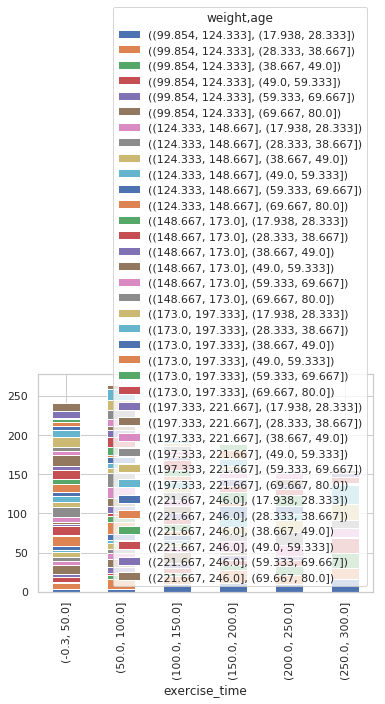

In [140]:
ct.plot(kind='bar', stacked=True)


In [0]:
bat

In [0]:
pt = pd.pivot_table(df, values='exercise_time', index=weight_bins)

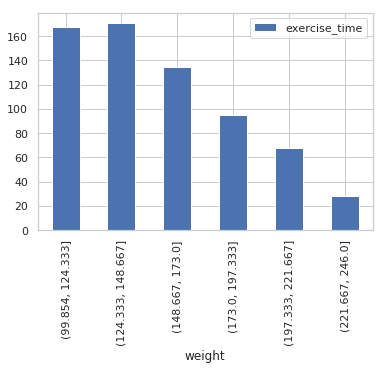

In [142]:
pt.plot.bar();

In [144]:
pt.plot.bar

<bound method FramePlotMethods.bar of <pandas.plotting._core.FramePlotMethods object at 0x7fe4c2c89da0>>

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


In [0]:
# 1. The variable type in the dataset is continuous 
# 2. 
# 3. The spurious relationship here is age in relation to the other variables (exercise time and weight). Exercise time and weight have a real relationship. 

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)